# Data programming with Snorkel: TubeSpam

## Preamble

In [1]:
# Importations.
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from textblob import TextBlob
from snorkel.labeling import labeling_function
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LFAnalysis
from snorkel.labeling.lf.nlp import nlp_labeling_function
from snorkel.labeling.model import MajorityLabelVoter
from snorkel.labeling.model import LabelModel
from snorkel.labeling import filter_unlabeled_dataframe
from snorkel.labeling import LabelingFunction
from snorkel.analysis import get_label_buckets
from snorkel.preprocess import preprocessor
from snorkel.preprocess.nlp import SpacyPreprocessor
from snorkel.utils import probs_to_preds
from sklearn.model_selection import train_test_split
import itertools

# Define random state seed to be used throughout.
seed = 123

## Define functions

## Read data

In [2]:
# Read data files.
df = pd.read_csv("../data/TubeSpam/TubeSpam.csv")

# Explore data.
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  1956 non-null   object
 1   AUTHOR      1956 non-null   object
 2   DATE        1711 non-null   object
 3   CONTENT     1956 non-null   object
 4   CLASS       1956 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 76.5+ KB
None


,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1


## Process data

In [3]:
# Change column names to match Snorkel tutorial.
df.columns = ["ID", "author", "date", "text", "label"]

In [4]:
# Train-test split (80% / 20%, stratified by gold label value).
X_train, X_test, y_train, y_test = train_test_split(df["text"], 
                                                    df["label"], 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify = df["label"])
df_train = df.iloc[X_train.index].reset_index(drop = True)
df_test = df.iloc[X_test.index].reset_index(drop = True)

# Set data types.
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = y_train.to_numpy(dtype = int)
y_test = y_test.to_numpy(dtype = int)

print(df_train.info())
display(df_train.head())
print(df_test.info())
display(df_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564 entries, 0 to 1563
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      1564 non-null   object
 1   author  1564 non-null   object
 2   date    1367 non-null   object
 3   text    1564 non-null   object
 4   label   1564 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 61.2+ KB
None


,ID,author,date,text,label
0,z124elbgazqmuhvs5230ut14uta5irenh,Agarra Mela,2014-11-08T09:32:14,"how does this video have 2,127,322,484 views i...",0
1,z12kcfcxyvb1cxhls220s3g4jlrtuppxg04,Eli Zabeth,2015-05-17T01:14:28.368000,In my head this is like 2 years ago.. Time FLIES﻿,0
2,LZQPQhLyRh9U7Lv_DKpJ7lawpBCotxfgHzBy93Tk028,LEONARDO CAETANO,2014-01-27T19:36:00,2 Billions in 2014,0
3,LneaDw26bFu-16wpkbRY_POG-WA_Hnc6J0bNJPD0g-k,Marko Vukoja,NaN,wtf. subscribe my channel thanx ;),1
4,z13oe5si1ouygx2dv22vcrb5qouetpjz404,Brian Brai,2015-05-28T08:57:27.399000,Omg﻿,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      392 non-null    object
 1   author  392 non-null    object
 2   date    344 non-null    object
 3   text    392 non-null    object
 4   label   392 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 15.4+ KB
None


,ID,author,date,text,label
0,z13mxjrbuyv5slha204cjdwg0wauylyap3w,Peter Wilkes,2014-09-15T15:48:57,"really want this video to get 1 billion views,...",0
1,z120uhiw0ubhcnxvi23uw5oorpuncvso204,tombraiderxXx12,2014-09-07T18:38:10,I'm not a big fan of the song but this video i...,0
2,_2viQ_Qnc6-pY-1yR6K2FhmC5i48-WuNx5CumlHLDAI,Sabina Pearson-Smith,2013-07-13T13:14:30.021000,I love this song for two reasons: 1.it is abou...,0
3,z13wtr2yssezhdaqa04cjvbody3qwjhpwk00k,Kirill Nazarethian,2014-11-07T22:59:37,2:05. Hahahahah ﻿,0
4,z12wuz2qqnawe50js04cejpzosrzdr0r1k40k,Dana Matich,2014-11-08T03:32:55,Hey guys! Check this out: Kollektivet - Don't ...,1


In [5]:
# Split off validation set from training set.
# Train-val split (90% / 10%, stratified by gold label value).
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size = 0.1, 
                                                  random_state = 42,
                                                  stratify = y_train)
df_train = df.iloc[X_train.index].reset_index(drop = True)
df_val = df.iloc[X_val.index].reset_index(drop = True)

# Set data types.
X_train = pd.DataFrame(X_train)
X_val = pd.DataFrame(X_val)

print(df_train.info())
display(df_train.head())
print(df_val.info())
display(df_val.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407 entries, 0 to 1406
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      1407 non-null   object
 1   author  1407 non-null   object
 2   date    1229 non-null   object
 3   text    1407 non-null   object
 4   label   1407 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 55.1+ KB
None


,ID,author,date,text,label
0,z12afdtaypuat3t5s04ccv4g4xe1elvbcdw,Lindsay Wofford,2014-11-07T13:12:45,What is he saying?!?!?!?!?!?!?!?$? ﻿,0
1,z130drwgasjgevh0n234ht3gfrmugfguz,Guren - MKII,2014-10-01T19:53:07.387000,everyday i&#39;m subscribe﻿,1
2,z13fwnbh5qusx1olr23bcfgjbxiljjv4u04,Flynn Rider,2014-08-20T19:04:01,Watch Maroon 5's latest 2nd single from V (It ...,1
3,z12qzzbpbzn4c5zwu04cir5gmzfozhy4cjk,lebanonwarior1,2014-11-06T18:07:21,Song name??﻿,0
4,z12cvbyjjmuwvxivx223tpujulrwwdt5j04,ampai gmuer,2015-01-27T13:23:56.061000,Check out this playlist on YouTube:👿👳👳👳👳👳﻿,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      157 non-null    object
 1   author  157 non-null    object
 2   date    138 non-null    object
 3   text    157 non-null    object
 4   label   157 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 6.3+ KB
None


,ID,author,date,text,label
0,z13fehihaneyzh3wp04cfxrwkyfkwvgoex00k,pratik patel,2015-05-23T05:28:49.504000,"mindblowing dance.,.,.superbbb song﻿",0
1,LneaDw26bFt7AvG8x15igOZvrWApak5Zh5-PPag9YTs,themagicmangotree,NaN,Check out my channel for funny skits! Thanks!,1
2,z13vc32olxm2znkjz04cd35gnozjebqhlig,TheLegitBroz,2014-11-08T00:26:35,The Funny Thing Is That this song was made in ...,0
3,z13ohniidsqhcjs1k22ti544qybadb25b04,reesekupp24,2015-05-14T14:10:58.987000,Check out this video on YouTube:﻿,1
4,z124inzqgoyeh33uw23iibficv2kuf2nx,anthony Jennings,2014-11-07T23:26:04,"People Who Say That ""This Song Is Too Old Now,...",0


1    0.513804
0    0.486196
Name: label, dtype: float64


<AxesSubplot:>

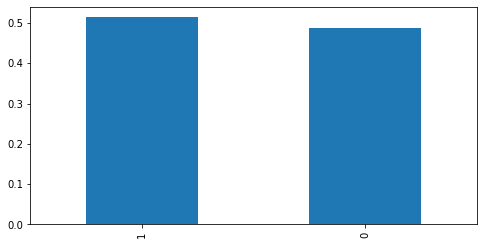

In [6]:
# View gold label distribution.
print(df["label"].value_counts(normalize = True))
df["label"].value_counts(normalize = True).plot.bar(figsize = (8, 4))

1    0.513859
0    0.486141
Name: label, dtype: float64


<AxesSubplot:>

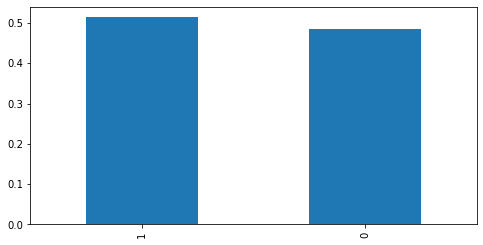

In [7]:
print(df_train["label"].value_counts(normalize = True))
df_train["label"].value_counts(normalize = True).plot.bar(figsize = (8, 4))

1    0.512755
0    0.487245
Name: label, dtype: float64


<AxesSubplot:>

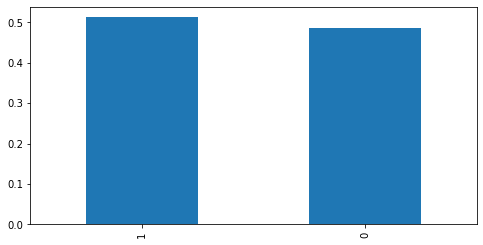

In [8]:
print(df_test["label"].value_counts(normalize = True))
df_test["label"].value_counts(normalize = True).plot.bar(figsize = (8, 4))

1    0.515924
0    0.484076
Name: label, dtype: float64


<AxesSubplot:>

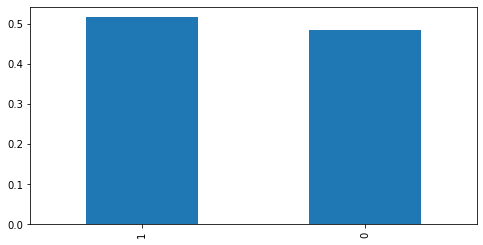

In [9]:
print(df_val["label"].value_counts(normalize = True))
df_val["label"].value_counts(normalize = True).plot.bar(figsize = (8, 4))

## Labeling functions

### Macros

In [10]:
# Label macros.
ABSTAIN = -1
HAM = 0
SPAM = 1

### Functions

In [11]:
# Define labeling functions with @labeling_function() decorator.

@labeling_function()
def check(x):
    return SPAM if "check" in x.text.lower() else ABSTAIN

@labeling_function()
def check_out(x):
    return SPAM if "check out" in x.text.lower() else ABSTAIN

# Use regular expressions.
@labeling_function()
def regex_check_out(x):
    return SPAM if re.search(r"check.*out", x.text, flags = re.I) else ABSTAIN

# Define heuristic LFs.
@labeling_function()
def short_comment(x):
    """Ham comments are often short, such as 'cool video!'"""
    return HAM if len(x.text.split()) < 5 else ABSTAIN

# Construct basic keyword lookup LFs.
def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN

def make_keyword_lf(keywords, label = SPAM):
    return LabelingFunction(
        name = f"keyword_{keywords[0]}",
        f = keyword_lookup,
        resources = dict(keywords = keywords, label = label),
    )

"""Spam comments talk about 'my channel', 'my video', etc."""
keyword_my = make_keyword_lf(keywords = ["my"])

"""Spam comments ask users to subscribe to their channels."""
keyword_subscribe = make_keyword_lf(keywords = ["subscribe"])

"""Spam comments post links to other channels."""
keyword_link = make_keyword_lf(keywords = ["http"])

"""Spam comments make requests rather than commenting."""
keyword_please = make_keyword_lf(keywords = ["please", "plz"])

"""Ham comments actually talk about the video's content."""
keyword_song = make_keyword_lf(keywords = ["song"], label = HAM)

# The SpacyPreprocessor parses the text in text_field and
# stores the new enriched representation in doc_field.
spacy = SpacyPreprocessor(text_field = "text", doc_field = "doc", memoize = True)

@labeling_function(pre = [spacy])
def has_person(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN
    
@nlp_labeling_function()
def has_person_nlp(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN
    
# Write an LF that uses a third-party model.
@preprocessor(memoize = True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

# Pick reasonable threshold and write corresponding labeling function.
@labeling_function(pre = [textblob_sentiment])
def textblob_polarity(x):
    return HAM if x.polarity > 0.9 else ABSTAIN

# Do the same for subjectivity scores, using memoized `Preprocessor` outputs.
@labeling_function(pre = [textblob_sentiment])
def textblob_subjectivity(x):
    return HAM if x.subjectivity >= 0.5 else ABSTAIN

## Apply labeling functions

In [12]:
# Apply LFs to dataframe.
lfs = [keyword_my,
       keyword_subscribe,
       keyword_link,
       keyword_please,
       keyword_song,
       regex_check_out,
       short_comment,
       has_person_nlp,
       textblob_polarity,
       textblob_subjectivity]
applier = PandasLFApplier(lfs = lfs)
L_train = applier.apply(df = df_train)
L_val = applier.apply(df = df_val)
L_test = applier.apply(df = df_test)

100%|████████████████████████████████████████| 392/392 [00:03<00:00, 120.24it/s]


In [13]:
# TRAIN: Summarize coverage, conflicts, empirical accurcacy of LFs.
LFAnalysis(L_train, lfs).lf_summary(y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  0  1] as ke

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
keyword_my,0,[1],0.190476,0.181237,0.113006,235,33,0.876866
keyword_subscribe,1,[1],0.117271,0.100213,0.066809,163,2,0.987879
keyword_http,2,[1],0.104478,0.085288,0.071784,138,9,0.938776
keyword_please,3,[1],0.104478,0.099502,0.054016,144,3,0.979592
keyword_song,4,[0],0.159915,0.131485,0.046908,166,59,0.737778
regex_check_out,5,[1],0.228145,0.131485,0.085999,321,0,1.000000
short_comment,6,[0],0.249467,0.169865,0.062544,257,94,0.732194
has_person_nlp,7,[0],0.104478,0.083156,0.037669,92,55,0.625850
textblob_polarity,8,[0],0.051173,0.044776,0.007107,60,12,0.833333
textblob_subjectivity,9,[0],0.385217,0.296375,0.156361,322,220,0.594096


In [14]:
# VAL: Summarize coverage, conflicts, empirical accurcacy of LFs.
LFAnalysis(L_val, lfs).lf_summary(y_val)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  0  1] as ke

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
keyword_my,0,[1],0.216561,0.191083,0.108280,27,7,0.794118
keyword_subscribe,1,[1],0.159236,0.146497,0.089172,25,0,1.000000
keyword_http,2,[1],0.082803,0.070064,0.063694,13,0,1.000000
keyword_please,3,[1],0.082803,0.082803,0.038217,13,0,1.000000
keyword_song,4,[0],0.178344,0.140127,0.038217,25,3,0.892857
regex_check_out,5,[1],0.235669,0.127389,0.089172,37,0,1.000000
short_comment,6,[0],0.229299,0.159236,0.063694,27,9,0.750000
has_person_nlp,7,[0],0.114650,0.070064,0.019108,16,2,0.888889
textblob_polarity,8,[0],0.057325,0.057325,0.019108,6,3,0.666667
textblob_subjectivity,9,[0],0.331210,0.254777,0.171975,24,28,0.461538


In [15]:
# TEST: Summarize coverage, conflicts, empirical accurcacy of LFs.
LFAnalysis(L_test, lfs).lf_summary(y_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[-1  0  1] as ke

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
keyword_my,0,[1],0.198980,0.196429,0.132653,70,8,0.897436
keyword_subscribe,1,[1],0.147959,0.117347,0.081633,57,1,0.982759
keyword_http,2,[1],0.094388,0.079082,0.058673,35,2,0.945946
keyword_please,3,[1],0.127551,0.125000,0.071429,50,0,1.000000
keyword_song,4,[0],0.158163,0.127551,0.066327,38,24,0.612903
regex_check_out,5,[1],0.214286,0.135204,0.104592,84,0,1.000000
short_comment,6,[0],0.257653,0.165816,0.068878,73,28,0.722772
has_person_nlp,7,[0],0.104592,0.081633,0.028061,30,11,0.731707
textblob_polarity,8,[0],0.028061,0.028061,0.000000,10,1,0.909091
textblob_subjectivity,9,[0],0.380102,0.272959,0.173469,81,68,0.543624


## Dummy accuracy

In [16]:
# View "dummy" accuracy if predicting majority class every time.
print("Accuracy if predicting majority class", 
      df_test["label"].value_counts(normalize = True).max())

Accuracy if predicting majority class 0.5127551020408163


## Majority vote

In [17]:
# Majority vote model.
majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L = L_train)

In [18]:
# Compute majority vote performance metrics.
majority_scores = majority_model.score(L = L_test, 
                                       Y = y_test, 
                                       tie_break_policy = "abstain",
                                       metrics = ["f1", "accuracy", "precision", 
                                                  "recall", "roc_auc", "coverage"])

In [19]:
# Compare model performance metrics.
majority_f1 = majority_scores.get("f1")
majority_acc = majority_scores.get("accuracy")
majority_prec = majority_scores.get("precision")
majority_rec = majority_scores.get("recall")
majority_roc = majority_scores.get("roc_auc")
majority_cov = majority_scores.get("coverage")
print(f"{'Majority Model F1:':<25} {majority_f1 * 100:.1f}%")
print(f"{'Majority Model Accuracy:':<25} {majority_acc * 100:.1f}%")
print(f"{'Majority Model Precision:':<25} {majority_prec * 100:.1f}%")
print(f"{'Majority Model Recall:':<25} {majority_rec * 100:.1f}%")
print(f"{'Majority Model AUC ROC:':<25} {majority_roc * 100:.1f}%")
print(f"{'Majority Model Coverage:':<25} {majority_cov * 100:.1f}%")

Majority Model F1:        91.4%
Majority Model Accuracy:  92.2%
Majority Model Precision: 99.2%
Majority Model Recall:    84.7%
Majority Model AUC ROC:   92.0%
Majority Model Coverage:  75.3%


## Model tuning

Tune labeling model [hyperparameters](https://snorkel.readthedocs.io/en/v0.9.7/packages/_autosummary/labeling/snorkel.labeling.model.label_model.LabelModel.html#snorkel.labeling.model.label_model.LabelModel) using grid search.

In [20]:
# Search space.
epochs = [50, 100, 250]
l2 = [0.0, 0.2, 0.4]
lr = [0.001, 0.01, 0.1]

# Take cartesian product to obtain grid search space.
search_space = list(itertools.product(epochs, l2, lr))
print("\n--- HYPERPARAMETER SEARCH SPACE: ---\n")
print("Total combinations:", len(search_space))
print()
print(search_space)


--- HYPERPARAMETER SEARCH SPACE: ---

Total combinations: 27

[(50, 0.0, 0.001), (50, 0.0, 0.01), (50, 0.0, 0.1), (50, 0.2, 0.001), (50, 0.2, 0.01), (50, 0.2, 0.1), (50, 0.4, 0.001), (50, 0.4, 0.01), (50, 0.4, 0.1), (100, 0.0, 0.001), (100, 0.0, 0.01), (100, 0.0, 0.1), (100, 0.2, 0.001), (100, 0.2, 0.01), (100, 0.2, 0.1), (100, 0.4, 0.001), (100, 0.4, 0.01), (100, 0.4, 0.1), (250, 0.0, 0.001), (250, 0.0, 0.01), (250, 0.0, 0.1), (250, 0.2, 0.001), (250, 0.2, 0.01), (250, 0.2, 0.1), (250, 0.4, 0.001), (250, 0.4, 0.01), (250, 0.4, 0.1)]


In [21]:
# Validation loop.
# Select optimal model based on minimizing false negatives,
# i.e. look at recall (syn. sensitivity, TPR), f1, etc.
recalls = []
f1s = []
rocs = []
accuracies = []
precisions = []
for hparams in search_space:
    
    # Extract hyperparameter values.
    n_epochs = hparams[0]
    l2 = hparams[1]
    lr = hparams[2]
    
    # Label model.
    label_model = LabelModel(cardinality = 2, verbose = True)
    label_model.fit(L_train = L_train, 
                    #Y_dev = y_val,
                    #class_balance = [0.7, 0.3], 
                    n_epochs = n_epochs, 
                    l2 = l2,
                    lr = lr,
                    optimizer = "sgd",
                    seed = seed)

    # Compute model performance metrics.
    label_scores = label_model.score(L = L_val, 
                                     Y = y_val, 
                                     tie_break_policy = "abstain",
                                     metrics = ["f1", "accuracy", "precision", 
                                                "recall", "roc_auc", "coverage"])
    
    

    
    print("\n--- HYPERPARAMETERS (epochs, l2, lr): ---")
    print(hparams)

    label_f1 = label_scores.get("f1") * 100
    label_acc = label_scores.get("accuracy") * 100
    label_prec = label_scores.get("precision") * 100
    label_rec = label_scores.get("recall") * 100
    label_roc = label_scores.get("roc_auc") * 100
    label_cov = label_scores.get("coverage") * 100
    print("F1: {} | Accuracy: {} | Precision: {} | Recall: {} | AUC ROC: {} | Coverage: {}".format(round(label_f1, 2),
                                                                                                   round(label_acc, 2),
                                                                                                   round(label_prec, 2),
                                                                                                   round(label_rec, 2),
                                                                                                   round(label_roc, 2),
                                                                                                   round(label_cov, 2)))
    print("----------------------------------------------------")
    
    recalls.append(label_rec)
    f1s.append(label_f1)
    rocs.append(label_roc)
    accuracies.append(label_acc)
    precisions.append(label_prec)

100%|██████████████████████████████████████| 50/50 [00:00<00:00, 1468.17epoch/s]



--- HYPERPARAMETERS (epochs, l2, lr): ---
(50, 0.0, 0.001)
F1: 75.81 | Accuracy: 78.87 | Precision: 95.92 | Recall: 62.67 | AUC ROC: 94.91 | Coverage: 90.45
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(50, 0.0, 0.01)
F1: 84.06 | Accuracy: 84.51 | Precision: 92.06 | Recall: 77.33 | AUC ROC: 90.75 | Coverage: 90.45
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(50, 0.0, 0.1)
F1: 86.11 | Accuracy: 85.92 | Precision: 89.86 | Recall: 82.67 | AUC ROC: 84.98 | Coverage: 90.45
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(50, 0.2, 0.001)
F1: 75.81 | Accuracy: 78.87 | Precision: 95.92 | Recall: 62.67 | AUC ROC: 94.91 | Coverage: 90.45
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(50, 0.2, 0.01)
F1: 86.13 | Accuracy: 86.62 | Precision: 95.16 | Recall: 78.67 | AUC ROC: 92.66 | Coverage: 90.45
--

  0%|                                                | 0/100 [00:00<?, ?epoch/s]


--- HYPERPARAMETERS (epochs, l2, lr): ---
(50, 0.2, 0.1)
F1: 86.71 | Accuracy: 86.62 | Precision: 91.18 | Recall: 82.67 | AUC ROC: 91.9 | Coverage: 90.45
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(50, 0.4, 0.001)
F1: 75.81 | Accuracy: 78.87 | Precision: 95.92 | Recall: 62.67 | AUC ROC: 94.91 | Coverage: 90.45
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(50, 0.4, 0.01)
F1: 85.93 | Accuracy: 86.62 | Precision: 96.67 | Recall: 77.33 | AUC ROC: 94.73 | Coverage: 90.45
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(50, 0.4, 0.1)
F1: 85.93 | Accuracy: 86.62 | Precision: 96.67 | Recall: 77.33 | AUC ROC: 94.79 | Coverage: 90.45
----------------------------------------------------


  0%|                                                | 0/100 [00:00<?, ?epoch/s]


--- HYPERPARAMETERS (epochs, l2, lr): ---
(100, 0.0, 0.001)
F1: 81.54 | Accuracy: 83.1 | Precision: 96.36 | Recall: 70.67 | AUC ROC: 94.83 | Coverage: 90.45
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(100, 0.0, 0.01)
F1: 82.01 | Accuracy: 82.39 | Precision: 89.06 | Recall: 76.0 | AUC ROC: 87.94 | Coverage: 90.45
----------------------------------------------------


  0%|                                                | 0/100 [00:00<?, ?epoch/s]


--- HYPERPARAMETERS (epochs, l2, lr): ---
(100, 0.0, 0.1)
F1: 86.11 | Accuracy: 85.92 | Precision: 89.86 | Recall: 82.67 | AUC ROC: 84.98 | Coverage: 90.45
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(100, 0.2, 0.001)
F1: 81.54 | Accuracy: 83.1 | Precision: 96.36 | Recall: 70.67 | AUC ROC: 94.93 | Coverage: 90.45
----------------------------------------------------


100%|████████████████████████████████████| 100/100 [00:00<00:00, 1360.01epoch/s]



--- HYPERPARAMETERS (epochs, l2, lr): ---
(100, 0.2, 0.01)
F1: 84.29 | Accuracy: 84.51 | Precision: 90.77 | Recall: 78.67 | AUC ROC: 91.22 | Coverage: 90.45
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(100, 0.2, 0.1)
F1: 86.71 | Accuracy: 86.62 | Precision: 91.18 | Recall: 82.67 | AUC ROC: 91.58 | Coverage: 90.45
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(100, 0.4, 0.001)
F1: 81.54 | Accuracy: 83.1 | Precision: 96.36 | Recall: 70.67 | AUC ROC: 94.99 | Coverage: 90.45
----------------------------------------------------


 66%|███████████████████████▉            | 166/250 [00:00<00:00, 1652.55epoch/s]


--- HYPERPARAMETERS (epochs, l2, lr): ---
(100, 0.4, 0.01)
F1: 85.93 | Accuracy: 86.62 | Precision: 96.67 | Recall: 77.33 | AUC ROC: 94.73 | Coverage: 90.45
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(100, 0.4, 0.1)
F1: 85.93 | Accuracy: 86.62 | Precision: 96.67 | Recall: 77.33 | AUC ROC: 94.73 | Coverage: 90.45
----------------------------------------------------


  0%|                                                | 0/250 [00:00<?, ?epoch/s]


--- HYPERPARAMETERS (epochs, l2, lr): ---
(250, 0.0, 0.001)
F1: 85.93 | Accuracy: 86.62 | Precision: 96.67 | Recall: 77.33 | AUC ROC: 93.59 | Coverage: 90.45
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(250, 0.0, 0.01)
F1: 85.31 | Accuracy: 85.21 | Precision: 89.71 | Recall: 81.33 | AUC ROC: 84.68 | Coverage: 90.45
----------------------------------------------------


 49%|█████████████████▋                  | 123/250 [00:00<00:00, 1225.55epoch/s]


--- HYPERPARAMETERS (epochs, l2, lr): ---
(250, 0.0, 0.1)
F1: 86.11 | Accuracy: 85.92 | Precision: 89.86 | Recall: 82.67 | AUC ROC: 84.98 | Coverage: 90.45
----------------------------------------------------


  0%|                                                | 0/250 [00:00<?, ?epoch/s]


--- HYPERPARAMETERS (epochs, l2, lr): ---
(250, 0.2, 0.001)
F1: 85.93 | Accuracy: 86.62 | Precision: 96.67 | Recall: 77.33 | AUC ROC: 94.73 | Coverage: 90.45
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(250, 0.2, 0.01)
F1: 86.71 | Accuracy: 86.62 | Precision: 91.18 | Recall: 82.67 | AUC ROC: 91.58 | Coverage: 90.45
----------------------------------------------------


  0%|                                                | 0/250 [00:00<?, ?epoch/s]


--- HYPERPARAMETERS (epochs, l2, lr): ---
(250, 0.2, 0.1)
F1: 86.71 | Accuracy: 86.62 | Precision: 91.18 | Recall: 82.67 | AUC ROC: 91.58 | Coverage: 90.45
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(250, 0.4, 0.001)
F1: 81.54 | Accuracy: 83.1 | Precision: 96.36 | Recall: 70.67 | AUC ROC: 94.69 | Coverage: 90.45
----------------------------------------------------


100%|████████████████████████████████████| 250/250 [00:00<00:00, 1644.91epoch/s]



--- HYPERPARAMETERS (epochs, l2, lr): ---
(250, 0.4, 0.01)
F1: 85.93 | Accuracy: 86.62 | Precision: 96.67 | Recall: 77.33 | AUC ROC: 94.73 | Coverage: 90.45
----------------------------------------------------

--- HYPERPARAMETERS (epochs, l2, lr): ---
(250, 0.4, 0.1)
F1: 85.93 | Accuracy: 86.62 | Precision: 96.67 | Recall: 77.33 | AUC ROC: 94.73 | Coverage: 90.45
----------------------------------------------------


In [22]:
# Get hyparameter combinations with maximum metrics.
max_recall = max(recalls)
max_recall_indices = [i for i,j in enumerate(recalls) if j == max_recall]
hparams_max_recall = [search_space[i] for i in max_recall_indices]
print("\n--- HYPERPARAMETERS FOR MAX RECALL OF {}: ---\n".format(max_recall))
print("Total models with optimal recall:", len(hparams_max_recall))
print()
print(hparams_max_recall)

max_f1 = max(f1s)
max_f1_indices = [i for i,j in enumerate(f1s) if j == max_f1]
hparams_max_f1 = [search_space[i] for i in max_f1_indices]
print("\n--- HYPERPARAMETERS FOR MAX F1 OF {}: ---\n".format(max_f1))
print("Total models with optimal F1:", len(hparams_max_f1))
print()
print(hparams_max_f1)

max_accuracies = max(accuracies)
max_accuracies_indices = [i for i,j in enumerate(accuracies) if j == max_accuracies]
hparams_max_accuracies = [search_space[i] for i in max_accuracies_indices]
print("\n--- HYPERPARAMETERS FOR MAX ACCURACY OF {}: ---\n".format(max_accuracies))
print("Total models with optimal accuracy:", len(hparams_max_accuracies))
print()
print(hparams_max_accuracies)

max_precision = max(precisions)
max_precision_indices = [i for i,j in enumerate(precisions) if j == max_precision]
hparams_max_precision = [search_space[i] for i in max_precision_indices]
print("\n--- HYPERPARAMETERS FOR MAX PRECISION OF {}: ---\n".format(max_precision))
print("Total models with optimal precision:", len(hparams_max_precision))
print()
print(hparams_max_precision)

max_roc = max(rocs)
max_roc_indices = [i for i,j in enumerate(rocs) if j == max_roc]
hparams_max_roc = [search_space[i] for i in max_roc_indices]
print("\n--- HYPERPARAMETERS FOR MAX AUC ROC OF {}: ---\n".format(max_roc))
print("Total models with optimal AUC ROC:", len(hparams_max_roc))
print()
print(hparams_max_roc)


--- HYPERPARAMETERS FOR MAX RECALL OF 82.66666666666667: ---

Total models with optimal recall: 7

[(50, 0.0, 0.1), (50, 0.2, 0.1), (100, 0.0, 0.1), (100, 0.2, 0.1), (250, 0.0, 0.1), (250, 0.2, 0.01), (250, 0.2, 0.1)]

--- HYPERPARAMETERS FOR MAX F1 OF 86.7132867132867: ---

Total models with optimal F1: 4

[(50, 0.2, 0.1), (100, 0.2, 0.1), (250, 0.2, 0.01), (250, 0.2, 0.1)]

--- HYPERPARAMETERS FOR MAX ACCURACY OF 86.61971830985915: ---

Total models with optimal accuracy: 13

[(50, 0.2, 0.01), (50, 0.2, 0.1), (50, 0.4, 0.01), (50, 0.4, 0.1), (100, 0.2, 0.1), (100, 0.4, 0.01), (100, 0.4, 0.1), (250, 0.0, 0.001), (250, 0.2, 0.001), (250, 0.2, 0.01), (250, 0.2, 0.1), (250, 0.4, 0.01), (250, 0.4, 0.1)]

--- HYPERPARAMETERS FOR MAX PRECISION OF 96.66666666666667: ---

Total models with optimal precision: 8

[(50, 0.4, 0.01), (50, 0.4, 0.1), (100, 0.4, 0.01), (100, 0.4, 0.1), (250, 0.0, 0.001), (250, 0.2, 0.001), (250, 0.4, 0.01), (250, 0.4, 0.1)]

--- HYPERPARAMETERS FOR MAX AUC ROC OF 9

In [23]:
# Assess intersection of best models.
hparams_max = [hparams_max_accuracies, 
               hparams_max_f1, 
               hparams_max_recall,
               #hparams_max_roc,
               hparams_max_precision]
best_intersect = set.intersection(*map(set, hparams_max))
print("Total models at intersection:", len(best_intersect))
print(best_intersect)

Total models at intersection: 0
set()


In [24]:
# Hand select given multiple optimal models.
optimal_hparams = hparams_max_f1[0]
#optimal_hparams = list(best_intersect)[0]
print("Optimal hyperparameters =", optimal_hparams)

Optimal hyperparameters = (50, 0.2, 0.1)


## Train optimal labeling model

Model with best performance on validation set.

In [25]:
# Extract hyperparameter values.
n_epochs = optimal_hparams[0]
l2 = optimal_hparams[1]
lr = optimal_hparams[2]
    
# Label model.
label_model = LabelModel(cardinality = 2, verbose = True)
label_model.fit(L_train = L_train, 
                #Y_dev = y_val,
                #class_balance = [0.7, 0.3], 
                n_epochs = n_epochs, 
                l2 = l2,
                lr = lr,
                optimizer = "sgd",
                seed = seed)

# Compute model performance metrics for TEST SET.
label_scores = label_model.score(L = L_test, 
                                 Y = y_test, 
                                 tie_break_policy = "abstain",
                                 metrics = ["f1", "accuracy", "precision", 
                                            "recall", "roc_auc", "coverage"])
    
    

# Compare model performance metrics.
majority_f1 = majority_scores.get("f1")
majority_acc = majority_scores.get("accuracy")
majority_prec = majority_scores.get("precision")
majority_rec = majority_scores.get("recall")
majority_roc = majority_scores.get("roc_auc")
majority_cov = majority_scores.get("coverage")
print(f"{'Majority Model F1:':<25} {majority_f1 * 100:.1f}%")
print(f"{'Majority Model Accuracy:':<25} {majority_acc * 100:.1f}%")
print(f"{'Majority Model Precision:':<25} {majority_prec * 100:.1f}%")
print(f"{'Majority Model Recall:':<25} {majority_rec * 100:.1f}%")
print(f"{'Majority Model AUC ROC:':<25} {majority_roc * 100:.1f}%")
print(f"{'Majority Model Coverage:':<25} {majority_cov * 100:.1f}%")
print("--------------------------------------")
label_f1 = label_scores.get("f1")
label_acc = label_scores.get("accuracy")
label_prec = label_scores.get("precision")
label_rec = label_scores.get("recall")
label_roc = label_scores.get("roc_auc")
label_cov = label_scores.get("coverage")
print(f"{'Label Model F1:':<25} {label_f1 * 100:.1f}%")
print(f"{'Label Model Accuracy:':<25} {label_acc * 100:.1f}%")
print(f"{'Label Model Precision:':<25} {label_prec * 100:.1f}%")
print(f"{'Label Model Recall:':<25} {label_rec * 100:.1f}%")
print(f"{'Label Model AUC ROC:':<25} {label_roc * 100:.1f}%")
print(f"{'Label Model Coverage:':<25} {label_cov * 100:.1f}%")

100%|██████████████████████████████████████| 50/50 [00:00<00:00, 1101.13epoch/s]


Majority Model F1:        91.4%
Majority Model Accuracy:  92.2%
Majority Model Precision: 99.2%
Majority Model Recall:    84.7%
Majority Model AUC ROC:   92.0%
Majority Model Coverage:  75.3%
--------------------------------------
Label Model F1:           88.1%
Label Model Accuracy:     88.0%
Label Model Precision:    96.9%
Label Model Recall:       80.7%
Label Model AUC ROC:      93.3%
Label Model Coverage:     89.0%


## Export labeling function matrices

In [26]:
# Get predicted labels.
pred_train = label_model.predict(L_train)
pred_val = label_model.predict(L_val)
pred_test = label_model.predict(L_test)

print("TRAIN:\n", pd.Series(pred_train).value_counts())
print("VAL:\n", pd.Series(pred_val).value_counts())
print("TEST:\n", pd.Series(pred_test).value_counts())

TRAIN:
  0    677
 1    571
-1    159
dtype: int64
VAL:
  0    74
 1    68
-1    15
dtype: int64
TEST:
  0    189
 1    160
-1     43
dtype: int64


In [27]:
# Replace -1 with 0 (abstain = 0 in our model).
# Replace 0 with -1 (-1 is class label in our model).
pred_train = np.where(pred_train == -1, 5, pred_train)
pred_train = np.where(pred_train == 0, -1, pred_train)
pred_train = np.where(pred_train == 5, 0, pred_train)

pred_val = np.where(pred_val == -1, 5, pred_val)
pred_val = np.where(pred_val == 0, -1, pred_val)
pred_val = np.where(pred_val == 5, 0, pred_val)

pred_test = np.where(pred_test == -1, 5, pred_test)
pred_test = np.where(pred_test == 0, -1, pred_test)
pred_test = np.where(pred_test == 5, 0, pred_test)

print(pd.Series(pred_train).value_counts())
print(pd.Series(pred_test).value_counts())

-1    677
 1    571
 0    159
dtype: int64
-1    189
 1    160
 0     43
dtype: int64


In [28]:
# Replace -1 with 0 (abstain = 0 in our model).
# Replace 0 with -1 (-1 is class label in our model).

################################################################
# TRAIN.
L_train_new = np.where(L_train == -1, 5, L_train)
L_train_new = np.where(L_train_new == 0, -1, L_train_new)
L_train_new = np.where(L_train_new == 5, 0, L_train_new)
y_train_new = np.where(y_train == 0, -1, y_train)

df_L_train = pd.DataFrame(L_train_new)
df_L_train["Label"] = y_train_new
df_L_train["Snorkel"] = pred_train
display(df_L_train)
################################################################

################################################################
# VAL.
L_val_new = np.where(L_val == -1, 5, L_val)
L_val_new = np.where(L_val_new == 0, -1, L_val_new)
L_val_new = np.where(L_val_new == 5, 0, L_val_new)
y_val_new = np.where(y_val == 0, -1, y_val)

df_L_val = pd.DataFrame(L_val_new)
df_L_val["Label"] = y_val_new
df_L_val["Snorkel"] = pred_val
display(df_L_val)
################################################################

################################################################
# TEST.
L_test_new = np.where(L_test == -1, 5, L_test)
L_test_new = np.where(L_test_new == 0, -1, L_test_new)
L_test_new = np.where(L_test_new == 5, 0, L_test_new)
y_test_new = np.where(y_test == 0, -1, y_test)

df_L_test = pd.DataFrame(L_test_new)
df_L_test["Label"] = y_test_new
df_L_test["Snorkel"] = pred_test
display(df_L_test)
################################################################

,0,1,2,3,4,5,6,7,8,9,Label,Snorkel
0,0,0,0,0,0,0,0,0,0,0,-1,0
1,0,1,0,0,0,0,-1,0,0,-1,1,-1
2,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,-1,0,-1,0,0,0,-1,-1
4,0,0,0,0,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1402,0,0,0,0,0,0,-1,0,0,0,-1,-1
1403,1,0,0,0,0,1,0,0,0,0,1,1
1404,0,0,0,0,0,1,0,0,0,0,1,1
1405,0,0,0,0,0,1,0,0,0,-1,1,1


,0,1,2,3,4,5,6,7,8,9,Label,Snorkel
0,0,0,0,0,-1,0,-1,0,0,0,-1,-1
1,1,0,0,0,0,1,0,0,0,-1,1,1
2,0,0,0,0,-1,0,0,0,0,-1,-1,-1
3,0,0,0,0,0,1,0,0,0,0,1,1
4,0,0,0,0,-1,0,0,0,0,0,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
152,1,1,0,1,-1,1,0,0,0,-1,1,1
153,0,0,0,0,-1,0,0,0,0,0,-1,-1
154,0,0,0,0,0,1,0,0,0,0,1,1
155,0,0,0,0,0,1,0,0,0,0,1,1


,0,1,2,3,4,5,6,7,8,9,Label,Snorkel
0,0,0,0,0,0,0,0,0,0,0,-1,0
1,0,0,0,0,-1,0,0,0,0,0,-1,-1
2,0,0,0,0,-1,0,0,0,0,-1,-1,-1
3,0,0,0,0,0,0,-1,-1,0,0,-1,-1
4,1,0,0,0,0,1,0,0,0,-1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
387,0,0,0,0,0,0,0,0,0,0,-1,0
388,0,0,0,0,0,0,-1,0,0,0,-1,-1
389,1,0,1,0,0,0,0,0,0,-1,1,1
390,0,0,0,0,0,0,-1,0,0,-1,-1,-1


In [29]:
# Export labeling function matrices for external experiments.
df_L_train.to_csv("TubeSpam_tuned_lf_matrix_train.csv", index = False)
df_L_val.to_csv("TubeSpam_tuned_lf_matrix_val.csv", index = False)
df_L_test.to_csv("TubeSpam_tuned_lf_matrix_test.csv", index = False)

In [30]:
# Export raw dataframes, split by train / val / test.
df_train.to_csv("TubeSpam_tuned_train.csv", index = False)
df_val.to_csv("TubeSpam_tuned_val.csv", index = False)
df_test.to_csv("TubeSpam_tuned_test.csv", index = False)